<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://erachelson.github.io/RLclass_MVA/">https://erachelson.github.io/RLclass_MVA/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Chapter 5: Continuous actions in DQN algorithms</div>

<div class="alert alert-success">

**Learning outcomes**   
By the end of this chapter, you should be able to:
</div>

# Deep deterministic policy gradients

## The deterministic policy gradient theorem

Let us, once again, restart from approximate value iteration (AVI) as a sequence of risk minimization problems.

<div class="alert alert-success">

**Approximate value iteration as a sequence of risk minimization problems**  
$$\pi_n \in \mathcal{G} Q_n,$$
$$L_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho}\left[ \left( Q(s,a;\theta) - G^{\pi_n}_1(s,a,Q_n) \right)^2 \right],$$
$$\theta_{n+1} \in \arg\min_{\theta} L_n(\theta),$$
$$Q_{n+1}(s,a) = Q(s,a;\theta_{n+1}).$$
</div>

For deterministic policies, we have
$$\pi \in \mathcal{G} Q, \Leftrightarrow \pi(s) \in \arg\max_{a \in A} \left[Q(s,a)\right], \forall s\in S.$$

Finding $\pi \in \mathcal{G}Q$ was relatively easy as long as there were few, discrete actions. But when actions are continuous, solving a $\max_a$ problem is a continuous optimization problem on which we have little knowledge.

Let us turn to what we called "weak optimality" in a previous chapter, that is, given a distribution $\rho_0(s)$ on starting states, the search for a policy that maximizes $J(\pi) = \mathbb{E}_{s\sim \rho_0} [V^\pi(s)]$. As indicated in previous chapters, finding a policy which maximizes this *average value across states* is not necessarily the same as finding a policy which *dominates any other policy in every state*. But in most practical cases, $J(\pi)$ is a very reasonable and interesting proxy for optimality.

Recall that $V^\pi(s) = Q^\pi(s,\pi(s))$. 
So, for a given function $Q$, instead of looking for $\pi(s) \in \arg\max_{a \in A} \left[Q(s,a)\right], \forall s\in S$, we can redefine *greediness* and look for 
$$\pi \in \arg\max_{a \in A} \mathbb{E}_{s\sim \rho_0} [Q(s,\pi(s))] = J_Q(\pi).$$
If $Q=Q^*$, then a maximizer of this quantity is a maximizer of $J(\pi)$.

Now if $\pi$ is a parameterized function $\pi_w$, then one can try to approximate $\pi_n \in \mathcal{G}Q_n$ by taking gradient steps on $J_{Q_n}(\pi_w)$. This is the key idea behind deterministic policy gradient algorithms.

It relies on the deterministic policy gradient theorem, introduced by Silver at al (2014) in the **[Deterministic Policy Gradient Algorithms](https://proceedings.mlr.press/v32/silver14.html)** paper.

Let us write $J(w) = J(\pi_w)$ for a parametric policy $\pi_w$.  
Write also $\rho^{\pi_w}(s) = \sum\limits_{t = 0}^\infty \gamma^t p(S_t=s|\rho_0,\pi_w)$ for all $s \in S$ the state occupancy measure of $\pi_w$ given $\rho_0$.

<div class="alert alert-success">

**Deterministic policy gradient theorem**  
Consider a deterministic policy $\pi_w: S\rightarrow A$ interacting with an MDP $(S, A, p, r)$ with a starting state distribution $\rho_0$.  
We will drop the $w$ subscripts wherever unambiguous, to improve readability.    
If $p(s,a)$, $\nabla_a p(s'|s,a)$, $r(s,a)$, $\nabla_a r(s,a)$, $\rho_0(s)$, $\pi_w(s)$, and $\nabla_w\pi_w(s)$ all exist and are continuous in $(s,a,s')$, then 
$$\nabla_w J(w) = \mathbb{E}_{s\sim \rho^{\pi}} \left[ \nabla_a Q^{\pi}(s,a)|_{a=\pi(s)} \cdot \nabla_w \pi_w(s) \right].$$
</div>

Note that $\nabla_w \pi_w(s)$ is a Jacobian matrix where each column is the derivative of an action variable with respect to the parameters $w$.

Rewriting this theorem with partial derivatives, we have:
$$\nabla_w J(w) = \mathbb{E}_{s\sim \rho^{\pi}} \left[ \frac{\partial Q^{\pi}(s,a)}{\partial a}(s,\pi(s)) \cdot \frac{\partial \pi(s)}{\partial w}(s) \right].$$

This theorem looks like the chain rule applied to $J(\pi_w)$ but it's actually a bit more than that.

Let us write $J(w)=J(\pi_w)$ again.
\begin{align*}
J(w) &= \mathbb{E}_{s\sim \rho_0} [V^{\pi_w}(s)]\\
 &= \mathbb{E}_{s\sim \rho_0} [Q^{\pi_w}(s,\pi_w(s))]
\end{align*}

Let us take the gradient of this term with respect to $w$.
$$\nabla_w J(w) = \mathbb{E}_{s\sim \rho_0} \left[ \frac{\partial Q^{\pi_w}(s,\pi_w(s))}{\partial w} \right].$$

If we had had a fixed $Q$ instead of $Q^{\pi_w}$ in the expression above, we could have used the chain rule and we could have written:
$$\frac{\partial Q(s,\pi_w(s))}{\partial w}  = \frac{\partial Q(s,a)}{\partial a}(s,\pi_w(s)) \frac{\partial \pi_w(s)}{\partial w}(s).$$

But we don't have a fixed $Q$, and as soon as $w$ changes infinitesimally, $Q^{\pi_w}$ changes too, so this chain rule is not so straightforward.

The full proof of the deterministic policy gradient theorem is in the appendix of the aforementionned paper and we will not recall it here. In short, the derivation implies unfolding the sum over times steps of reward random variables in $Q^\pi$, which leads to the introduction of $\rho^\pi$.  

Instead, we will try to provide intuition as to why this gradient ascent direction makes sense in an AVI context.

## Connecting the DPG and AVI

**The intuition.**  
Suppose we have a current $Q_n$ in the AVI sequence, and we are searching for $\pi_n$, with the intention to define $Q_{n+1}$. Then, for each visited state $s$, $\pi_n(s)$ is a $Q_n$-greedy action $\pi_n(s) \in \arg\max_{a} Q_n(s,a)$. So, in each state, given a current $\pi_w$, the policy parameters should move in the direction of $\nabla_w Q_n(s,\pi_w(s))$. Since this should be true in all states visited by $\pi_w$, averaging these gradients according to $\rho^{\pi_w}$ makes sense.

**Understanding the deterministic policy gradient theorem: where $\infty$-horizon improvement and one-step greediness coincide.**  
Let $\pi_w$ be the current policy in the AVI process. Then if there is no approximation error, $Q_n = Q^{\pi_w}$. We want to find a policy that dominates over $\pi_w$. What the policy gradient theorem tells us is that the overall improvement step $\nabla_w J(w)$ of $\pi_w$ is found using gradients derived from the 1-step-lookahead value function $Q_n$ with respect to $\pi_w$. In other words, in $w$ specifically, the deterministic policy gradient $\nabla_w J(w)$ coincides with $\mathbb{E}_{s\sim \rho^{\pi_w}} [\nabla_w Q_n(s,\pi_w(s))]$. But this is only true in $w$, because of the tight coupling between $\rho^{\pi_w}$, $Q_n$, and $\pi_w$. Once the gradient step is taken, both $\rho^{\pi_w}$ and $Q^{\pi_w}$ change and need to be updated to perform future gradient steps: the gradient estimate can only use $Q_n$ because it was an estimate of $Q^{\pi_w}$. 

**Nuts and bolts of DPG.**   
Yet, provided we trust $Q_n$ to be close enough to $Q^{\pi_w}$ and provided we can draw from a distribution close enough to $\rho^{\pi_w}$, this enables building a Monte Carlo estimator of $\nabla_w J(w)$ by drawing samples according to $\rho^{\pi_w}$, summing the corresponding values of $Q_n(s,\pi_w(s))$ and taking the gradient with respect to $w$.
In practice, we often have a replay buffer which is representative not only of $\rho^{\pi_w}$, but rather of a mix of successive $\rho^{\pi_w}$. Nonetheless, this replay buffer will enable defining a loss function on the policy. Consequently, given a replay buffer distribution $\rho_n$ at iteration $n$, we can redefine the AVI sequence as:

$$L^\pi_n(w) = \mathbb{E}_{\rho_n} \left[ Q_n(s,\pi_w(s)) \right]$$
$$w_n = w_{n-1} +\alpha \nabla_w L^\pi_n(w_{n-1})$$
$$\pi_n = \pi_{w_n}$$
$$L^Q_n(\theta) = \frac{1}{2} \mathbb{E}_{(s,a) \sim \rho_n}\left[ \left( Q(s,a;\theta) - G^{\pi_n}_1(s,a,Q_n) \right)^2 \right]$$
$$\theta_{n+1} \in \arg\min_\theta L^Q_n(\theta)$$
$$Q_{n+1} = Q_{\theta_n}$$

In turn, this provides us with a direct way to implement a general **[Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971)** or DDPG (Lillicrap et al., 2016) algorithm. 

## Deep Deterministic Policy Gradient

Recall that (as in the previous chapter), a single gradient step makes for a poor function approximator. To compensate for this, we previously introduced two mechanisms: either take several gradient steps with respect to a given *target* network (we did it for $Q$ but the same idea applies to $\pi$), or implement a moving average. DDPG implements the latter. Define $\theta'$ and $w'$ the target networks' parameters, then $G^{\pi_n}_1(s,a,Q_n)$ in the Q-function loss becomes $G^{\pi_{w'}}_1(s,a,Q_{\theta'})$. 

So, after each drawn mini-batch:
$$w \leftarrow w + \alpha_w \nabla_w L^\pi_n(w),$$
$$\theta \leftarrow \theta - \alpha_\theta \nabla_\theta L^Q_n(\theta).$$
And the target networks are updated according to:
$$w' \leftarrow \tau w + (1-\tau) w',$$
$$\theta' \leftarrow \tau \theta + (1-\tau) \theta'.$$

In order to use libraries like `pytorch` which perform stochastic gradient descent (and not ascent), we redefine the policy update loss as $-Q(s,\pi(s))$.

Finally, we need to define the behavior policy. The policy update requires states to be drawn according to $\rho^\pi$, but the Q-function update requires to test all actions in the encountered states. Since we work with continuous actions, we turn to an exploration policy consisting of adding noise to the deterministic policy's action. Historically, this noise was a time-correlated Ornstein-Uhlenbeck noise but this later appeared to be unnecessary in practice and a simple normal distribution suffices.

Overall, the pseudo-code of DDPG is:

```
Initialize theta=theta' and w=w' 
Initialize replay buffer RB
s = env.init()
loop:
   Pick a = pi_w(s) + noise
   s',r = env.step(a)
   RB.append(s,a,r,s')
   minibatch = RB.sample()
   actor_loss(w) = MSE(Q(s,pi(s,w),theta)
   actor_loss.gradient_ascent_step()
   target_value(s,a) = r + gamma Q(s',pi(s',w'),theta')
   critic_loss(theta) = MSE(Q(s,a,theta), target_value(s,a))
   critic_loss.gradient_descent_step()
   s=s'
```

<div class="alert alert-warning">
    
**Exercise:**  
Declare a class for a Q-function neural network. Use two hidden layers with 256 neurons each.
</div>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Warning, this class only works for vector-shaped inputs (for images, it requires adjustments).
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.fc1 = nn.Linear(state_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

<div class="alert alert-warning">
    
**Exercise:**  
Declare a class for a policy neural network. Use two hidden layers with 256 neurons each.  
\[Optional\] Include an option for inputing upper and lower bounds to enable action spaces not centered on zero, and store and `action_scale` and an `action_bias` parameter.
</div>

In [2]:
import torch
import torch.nn as nn

# Warning, this class only works for vector-shaped inputs (for images, it requires adjustments).
class policyNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, action_dim)
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

<div class="alert alert-warning">
    
**Exercise:**  
Write a class that implements the DDPG pseudo-code.
</div>

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
from solutions.replay_buffer2 import ReplayBuffer
from tqdm import trange

class ddpg_agent:
    def __init__(self, config, value_network, policy_network):
        # networks
        device = "cuda" if next(value_network.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(value_network.parameters()).dtype
        self.Qfunction = value_network
        self.Q_target = deepcopy(self.Qfunction).to(device)
        self.pi = policy_network
        self.pi_target = deepcopy(self.pi).to(device)
        # parameters
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.95
        buffer_size = config['buffer_size'] if 'buffer_size' in config.keys() else int(1e5)
        self.memory = ReplayBuffer(buffer_size, device)
        self.batch_size = config['batch_size'] if 'batch_size' in config.keys() else 100
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.Q_optimizer = torch.optim.Adam(list(self.Qfunction.parameters()), lr=lr)
        self.pi_optimizer = torch.optim.Adam(list(self.pi.parameters()), lr=lr)
        self.tau = config['tau'] if 'tau' in config.keys() else 0.005
        self.exploration_noise = config['exploration_noise'] if 'exploration_noise' in config.keys() else 0.005
        self.delay_learning = config['delay_learning'] if 'delay_learning' in config.keys() else 1e4
        self.tqdm_disable = config['tqdm_disable'] if 'tqdm_disable' in config.keys() else True
        self.disable_episode_report = config['disable_episode_report'] if 'disable_episode_report' in config.keys() else True

    def hello(self):
        print("hello world")
    def train(self, env, max_steps):
        x,_ = env.reset()
        episode = 0
        episode_cum_reward = 0
        episode_return = []

        for time_step in trange(int(max_steps), disable=self.tqdm_disable):
            # step (policy + noise), add to rb
            if time_step > self.delay_learning:
                with torch.no_grad():
                    a = self.pi(torch.tensor(x,dtype=self.scalar_dtype))
                    a += torch.normal(0, self.pi.action_scale * self.exploration_noise)
                    a = a.cpu().numpy().clip(env.action_space.low, env.action_space.high)
            else:
                a = env.action_space.sample()
            y, r, done, trunc, _ = env.step(a)
            self.memory.append(x,a,r,y,done)
            episode_cum_reward += r
            
            # gradient step
            if time_step > self.delay_learning:
                X, A, R, Y, D = self.memory.sample(self.batch_size)
                ## Qfunction update
                with torch.no_grad():
                    next_actions = self.pi_target(Y)
                    QYA = self.Q_target(Y, next_actions)
                    #target = torch.addcmul(R, 1-D, QY, value=self.gamma)
                    target = R + self.gamma * (1-D) * QYA.view(-1)
                QXA = self.Qfunction(X, A).view(-1)
                Qloss = F.mse_loss(QXA,target)
                self.Q_optimizer.zero_grad()
                Qloss.backward()
                self.Q_optimizer.step()
                ## policy update
                pi_loss = -self.Qfunction(X, self.pi(X)).mean()
                self.pi_optimizer.zero_grad()
                pi_loss.backward()
                self.pi_optimizer.step()
                
                # target networks update
                for param, target_param in zip(self.pi.parameters(), self.pi_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                for param, target_param in zip(self.Qfunction.parameters(), self.Q_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                
            # if done, print episode info
            if done or trunc:
                x, _ = env.reset()
                episode_return.append(episode_cum_reward)
                if not self.disable_episode_report:
                    print("Episode ", '{:2d}'.format(episode), 
                          ", buffer size ", '{:4d}'.format(len(self.memory)), 
                          ", episode return ", '{:4.1f}'.format(episode_cum_reward), 
                          sep='')
                episode += 1
                episode_cum_reward = 0
            else:
                x=y
        return episode_return

<div class="alert alert-warning">
    
**Exercise:**  
Test your code on Gymnasium's [bipedal walker environment](https://gymnasium.farama.org/environments/box2d/bipedal_walker/).  
Caveat: training might be long!
</div>

In [7]:
import gymnasium as gym

env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
config = {'gamma': .99,
          'buffer_size': 1e6,
          'learning_rate': 3e-4,
          'batch_size': 256,
          'tau': 0.005,
          'delay_learning': 1e4,
          'exploration_noise': .1,
          'tqdm_disable': False
         }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Qfunction = QNetwork(env).to(device)
policy = policyNetwork(env).to(device)

agent = ddpg_agent(config, Qfunction, policy)
episode_returns = agent.train(env, 2e4)

100%|██████████| 20000/20000 [01:06<00:00, 299.94it/s]


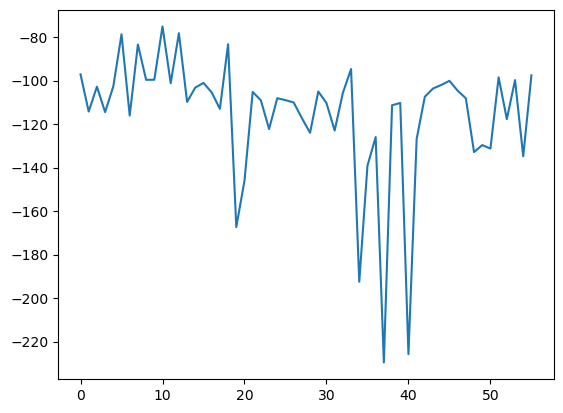

In [8]:
import matplotlib.pyplot as plt
plt.plot(episode_returns)

In [9]:
import gymnasium as gym

test_env = gym.make("BipedalWalker-v3", render_mode="human")
s,_ = test_env.reset()
with torch.no_grad():
    for t in range(1000):
        a = policy(torch.tensor(s)).numpy()
        s2,r,d,trunc,_ = test_env.step(a)
        test_env.render()
        s = s2
        if d:
            break

test_env.close()

<div class="alert alert-warning">
    
**Exercise:**  
Modify the `Qnetwork` and `policyNetwork` classes above to take images as inputs and run DDPG on Gymnasium's [car racing environment](https://gymnasium.farama.org/environments/box2d/car_racing/).
</div>

In [ ]:
#%load solutions/no_solution_yet.py

# TD3: improving value function approximation in DDPG

Just like DQN and other VI-based algorihtms, DDPG is prone to overestimation of the Q-function. This was improved in the discrete actions domain by [Double Q-learning](https://arxiv.org/abs/1509.06461) and its extension [Double DQN](https://ojs.aaai.org/index.php/AAAI/article/view/10295), taking the greedy action with respect to the current value network, while its value is taken using the target network.

Building on this idea, Fujimoto et al. introduced [Twin Delayed DDPG](https://arxiv.org/pdf/1802.09477.pdf) also known as TD3, as an improvement on DDPG which:
- defines double critics (as in DDQN),
- defines a new update target called *clipped Q-learning*,
- enables better fitting of $Q^\pi$ by $Q_n$, by performing two gradient steps on $\theta$ before each gradient step on $w$ and each target network update.
These three items motivate the name of the algorithm.

The clipped Q-learning target is:
$$y = r + \gamma \min_{i\in\{1,2\}} Q(s', \pi_w(s'); \theta'_i)$$

Additionally, TD3 improves generalization across actions by adding a clipped noise term to the actions in the target. This can be seen as a way to promote value function smoothness with respect to continuous actions (it is a very naive form of data augmentation). Hence, the target value above is changed to:
$$y = r + \gamma \min_{i\in\{1,2\}} Q(s', \pi_w(s') + \epsilon; \theta'_i)$$
where $\epsilon$ is drawn according to a clipped, centered Gaussian noise.

<div class="alert alert-warning">
    
**Exercise (discussion):**  
Does this make TD3 close to SARSA?
</div>

Overall, the pseudo-code of TD3 is:

```
Initialize theta1=theta1', theta2=theta2' and w=w' 
Initialize replay buffer RB
s = env.init()
loop:
   Pick a = pi_w(s) + noise
   s',r = env.step(a)
   RB.append(s,a,r,s')
   minibatch = RB.sample()
   next_action = pi(s',w') + clipped_noise
   target_value(s,a) = r + gamma min [ Q(s',next_action,theta1'), Q(s',next_action,theta2') ]
   critic1_loss(theta) = MSE(Q(s,a,theta1), target_value(s,a))
   critic2_loss(theta) = MSE(Q(s,a,theta2), target_value(s,a))
   critic_loss = critic1_loss + critic2_loss
   critic_loss.gradient_descent_step()
   only one step out of two:
      actor_loss(w) = MSE(Q1(s,pi(s,w),theta)
      actor_loss.gradient_ascent_step()
      target networks update
   s=s'
```

<div class="alert alert-warning">
    
**Exercise (discussion):**  
Implement the pseudo-code above.
</div>

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy
from solutions.replay_buffer2 import ReplayBuffer
from tqdm import trange

class td3_agent:
    def __init__(self, config, value_network1, value_network2, policy_network):
        # networks
        self.device = "cuda" if next(value_network1.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(value_network1.parameters()).dtype
        self.Qfunction1 = value_network1
        self.Qfunction2 = value_network2
        self.Q1_target = deepcopy(self.Qfunction1).to(device)
        self.Q2_target = deepcopy(self.Qfunction2).to(device)
        self.pi = policy_network
        self.pi_target = deepcopy(self.pi).to(device)
        # parameters
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.95
        buffer_size = config['buffer_size'] if 'buffer_size' in config.keys() else int(1e5)
        self.memory = ReplayBuffer(buffer_size, device)
        self.batch_size = config['batch_size'] if 'batch_size' in config.keys() else 100
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.Q_optimizer = torch.optim.Adam(list(Qfunction1.parameters()) + list(Qfunction2.parameters()), lr=lr)
        self.pi_optimizer = torch.optim.Adam(list(self.pi.parameters()), lr=lr)
        self.tau = config['tau'] if 'tau' in config.keys() else 0.005
        self.exploration_noise = config['exploration_noise'] if 'exploration_noise' in config.keys() else 0.005
        self.delay_learning = config['delay_learning'] if 'delay_learning' in config.keys() else 1e4
        self.action_noise_scale = config['action_noise_scale'] if 'action_noise_scale' in config.keys() else 0.2
        self.action_noise_clip = config['action_noise_clip'] if 'action_noise_clip' in config.keys() else 0.5
        self.policy_update_freq = config['policy_update_freq'] if 'policy_update_freq' in config.keys() else 2
        self.tqdm_disable = config['tqdm_disable'] if 'tqdm_disable' in config.keys() else True
        self.disable_episode_report = config['disable_episode_report'] if 'disable_episode_report' in config.keys() else True

    def hello(self):
        print("hello world")
    def train(self, env, max_steps):
        x,_ = env.reset()
        episode = 0
        episode_cum_reward = 0
        episode_return = []

        for time_step in trange(int(max_steps), disable=self.tqdm_disable):
            # step (policy + noise), add to rb
            if time_step > self.delay_learning:
                with torch.no_grad():
                    a = self.pi(torch.tensor(x,dtype=self.scalar_dtype))
                    a += torch.normal(0, self.pi.action_scale * self.exploration_noise)
                    a = a.cpu().numpy().clip(env.action_space.low, env.action_space.high)
            else:
                a = env.action_space.sample()
            y, r, done, trunc, _ = env.step(a)
            self.memory.append(x,a,r,y,done)
            episode_cum_reward += r
            
            # gradient step
            if time_step > self.delay_learning:
                X, A, R, Y, D = self.memory.sample(self.batch_size)
                ## Qfunction update
                with torch.no_grad():
                    # next action with noise
                    noise = torch.randn_like(A, device=self.device) * self.action_noise_scale
                    clipped_noise = noise.clamp(-self.action_noise_clip, self.action_noise_clip) * self.pi_target.action_scale
                    next_actions = self.pi_target(Y) + clipped_noise
                    next_actions=next_actions.clamp(env.action_space.low[0], env.action_space.high[0])
                    # clipped q-learning target
                    Q1YA = self.Q1_target(Y, next_actions)
                    Q2YA = self.Q2_target(Y, next_actions)
                    min_QYA = torch.min(Q1YA, Q2YA)
                    target = R + self.gamma * (1-D) * min_QYA.view(-1)
                # double q-network update
                Q1XA = self.Qfunction1(X, A).view(-1)
                Q2XA = self.Qfunction2(X, A).view(-1)
                Q1loss = F.mse_loss(Q1XA,target)
                Q2loss = F.mse_loss(Q2XA,target)
                Qloss = Q1loss + Q2loss
                self.Q_optimizer.zero_grad()
                Qloss.backward()
                self.Q_optimizer.step()
                ## policy update
                if time_step % self.policy_update_freq ==0:
                    pi_loss = -self.Qfunction1(X, self.pi(X)).mean()
                    self.pi_optimizer.zero_grad()
                    pi_loss.backward()
                    self.pi_optimizer.step()
                    # target networks update
                    for param, target_param in zip(self.pi.parameters(), self.pi_target.parameters()):
                        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                    for param, target_param in zip(self.Qfunction1.parameters(), self.Q1_target.parameters()):
                        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                    for param, target_param in zip(self.Qfunction2.parameters(), self.Q2_target.parameters()):
                        target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
            # if done, print episode info
            if done or trunc:
                x, _ = env.reset()
                episode_return.append(episode_cum_reward)
                if not self.disable_episode_report:
                    print("Episode ", '{:2d}'.format(episode), 
                          ", buffer size ", '{:4d}'.format(len(self.memory)), 
                          ", episode return ", '{:4.1f}'.format(episode_cum_reward), 
                          sep='')
                episode += 1
                episode_cum_reward = 0
            else:
                x=y
        return episode_return

In [24]:
import gymnasium as gym

env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
config = {'gamma': .99,
          'buffer_size': 1e6,
          'learning_rate': 3e-4,
          'batch_size': 256,
          'tau': 0.005,
          'delay_learning': 1e4,
          'exploration_noise': .1,
          'action_noise_scale': 0.2,
          'action_noise_clip"': 0.5,
          'policy_update_freq': 2,
          'tqdm_disable': False
         }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Qfunction1 = QNetwork(env).to(device)
Qfunction2 = QNetwork(env).to(device)
policy = policyNetwork(env).to(device)

agent = td3_agent(config, Qfunction1, Qfunction2, policy)
episode_returns = agent.train(env, 2e4)

100%|██████████| 20000/20000 [01:08<00:00, 294.03it/s]


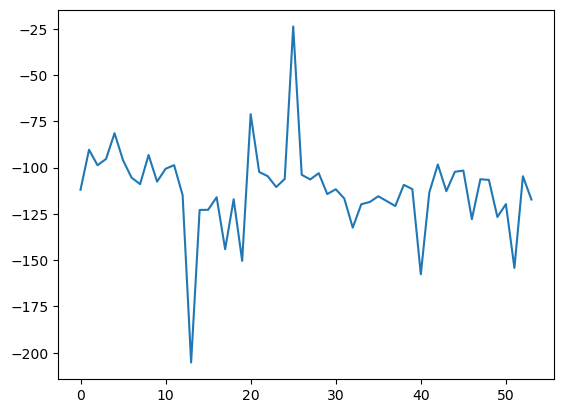

In [25]:
import matplotlib.pyplot as plt
plt.plot(episode_returns)

In [26]:
import gymnasium as gym

test_env = gym.make("BipedalWalker-v3", render_mode="human")
s,_ = test_env.reset()
with torch.no_grad():
    for t in range(1000):
        a = policy(torch.tensor(s)).numpy()
        s2,r,d,trunc,_ = test_env.step(a)
        test_env.render()
        s = s2
        if d:
            break

test_env.close()

# SAC